**Problem Statment :** Developing an efficient and automated process to shortlist the top 5 resumes that best match the specified job requirements.

**Source Data :** https://www.kaggle.com/code/akashkotal/resume-screening-with-nlp#3:-Train-Test-Data-and-Modeling

In [23]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 7.5 MB/s eta 0:00:00


In [24]:
# importing necessary libraries

import re
import nltk
import spacy
import string
import warnings
import contractions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from pprint import pprint
from tqdm.notebook import tqdm
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec

sns.set_style('darkgrid')
pd.set_option('display.max_columns', 100)

warnings.filterwarnings('ignore')

In [4]:
# Reading the csv file using pandas

data = pd.read_csv('UpdatedResumeDataSet.csv')
data.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


In [7]:
# printing shape and is there any null values

print("Shape of the dataset : ",data.shape)
print(data.isnull().sum())

Shape of the dataset :  (962, 2)
Category    0
Resume      0
dtype: int64


In [8]:
# basic describe of dataset

data.describe()

,Category,Resume
count,962,962
unique,25,166
top,Java Developer,"Technical Skills Web Technologies: Angular JS,..."
freq,84,18


In [9]:
# value count of each category in resume

category = data['Category'].value_counts().reset_index()
category

,Category,count
0,Java Developer,84
1,Testing,70
2,DevOps Engineer,55
3,Python Developer,48
4,Web Designing,45
5,HR,44
6,Hadoop,42
7,Blockchain,40
8,ETL Developer,40
9,Operations Manager,40


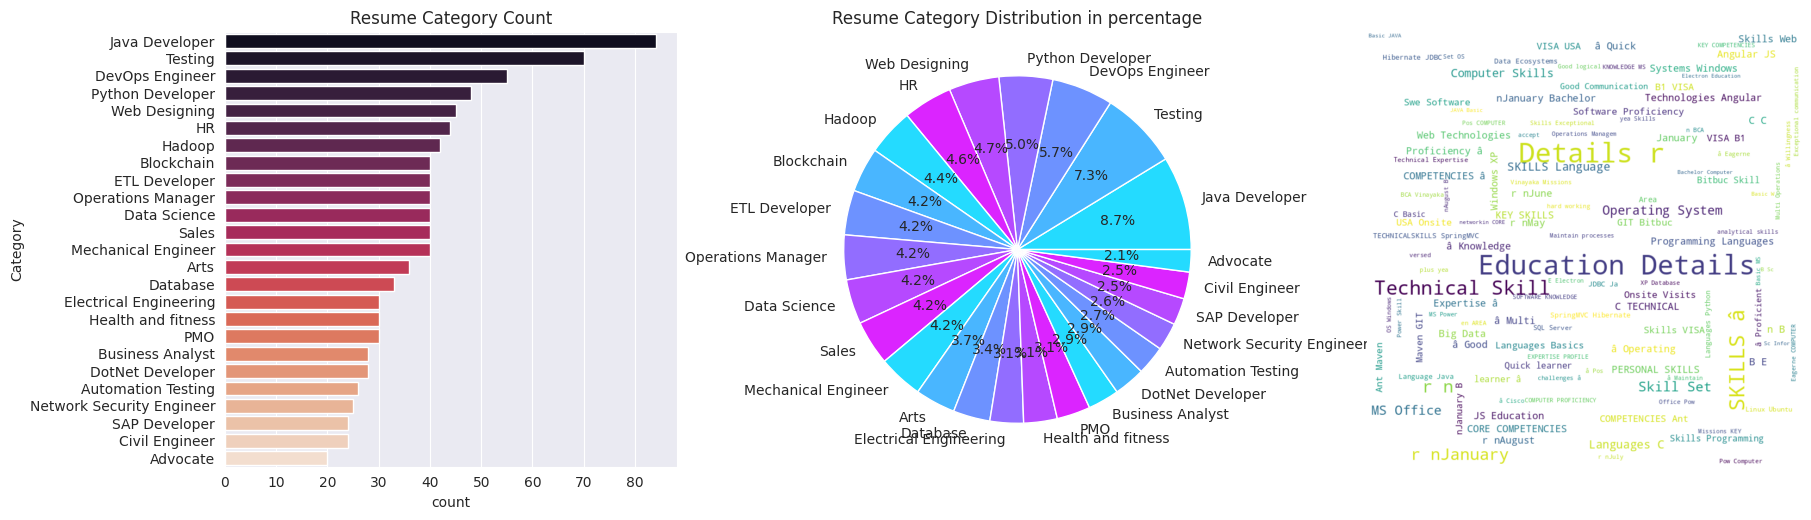

In [22]:
# Barplot for each value count in category
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
sns.barplot(x=category['count'], y=category['Category'], palette='rocket')
plt.title('Resume Category Count')

#pie chat to Resume Category Distribution in percentage
plt.subplot(1,3,2)
plt.pie(x=category['count'], labels=category['Category'], autopct='%1.1f%%', colors=sns.color_palette('cool'))
plt.title('Resume Category Distribution in percentage')

# Visulaize resume content using word cloud
wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      stopwords=set(STOP_WORDS),
                      max_font_size=50, min_font_size=10).generate(data['Resume'].to_string())

plt.subplot(1,3,3)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


In [26]:
def text_preprocessing(resumeText):
    resumeText = resumeText.lower() # capital words to small words
    resumeText = re.sub('http\S+\s*', ' ', resumeText)  # remove URLs
    resumeText = re.sub('RT|cc', ' ', resumeText)  # remove RT and cc
    resumeText = re.sub('#\S+', '', resumeText)  # remove hashtags
    resumeText = re.sub('@\S+', '  ', resumeText)  # remove mentions
    resumeText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', resumeText)  # remove punctuations
    resumeText = re.sub(r'[^\x00-\x7f]',r' ', resumeText)
    resumeText = re.sub('\s+', ' ', resumeText)  # remove extra whitespace
    resumeText = contractions.fix(resumeText) # fix contractions
    tokens = [word  for word in resumeText.split() if word not in STOP_WORDS] # apply stemming to the words not in stop word
    return ' '.join(tokens)

data['Cleaned_Resume'] = data['Resume'].apply(text_preprocessing)

data.head()

,Category,Resume,Cleaned_Resume
0,Data Science,Skills * Programming Languages: Python (pandas...,skills programming languages python pandas num...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,education details 2013 2017 b e uit rgpv data ...
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",areas interest deep learning control system de...
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,skills r python sap hana tableau sap hana sql ...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",education details mca ymcaust faridabad haryan...


In [38]:
# To train word2vec model we want to convert the sentence into list

resume = data['Cleaned_Resume'].values

#lets use spacy for faster tokenization
nlp = spacy.load('en_core_web_sm', disable=['tagger', 'ner'])
nlp.add_pipe('sentencizer')

def tokenize_sentence(sentence):
  sentence_corpus = []
  doc = nlp(sentence)
  sentence = [sent.text.strip() for sent in doc.sents]
  for sent in sentence:
    processed_sent_list = sent.split(" ")
    sentence_corpus.append(processed_sent_list)
  return sentence_corpus

data['tokenized_resume'] = data['Cleaned_Resume'].apply(tokenize_sentence)

corpus_data = data['tokenized_resume'].to_list()

# Flatten the nested lists
word2vec_corpus = [sentence for sublist in corpus_data for sentence in sublist]

In [41]:
model = Word2Vec(word2vec_corpus, min_count=1, workers=4, window=5, sg=1, negative=5, vector_size=300)

In [70]:
model.wv.most_similar('python')

[('memoization', 0.6793943643569946),
 ('django', 0.6742612719535828),
 ('flask', 0.6717460751533508),
 ('apex', 0.6688016653060913),
 ('braindatawire', 0.6673239469528198),
 ('cache', 0.6632054448127747),
 ('beautiful', 0.658290445804596),
 ('matplolib', 0.6562688946723938),
 ('liabrary', 0.6496606469154358),
 ('webframework', 0.6420939564704895)]

In [69]:
# Function to compute the average Word2Vec vector for a given text
def get_average_word2vec(text, model, vector_size):
    words = text.split()
    vector = np.zeros(vector_size)
    word_count = 0
    for word in words:
        if word in model.wv:
            vector += model.wv[word]
            word_count += 1
    if word_count != 0:
        vector /= word_count
    return vector

# Get the average Word2Vec vectors for all resumes
resume_vectors = np.array([get_average_word2vec(resume, model, 300) for resume in data['Cleaned_Resume']])

In [67]:
# Vectorize the query
query = "Role: Develop and implement machine learning models, statistical analyses, and data-driven algorithms to solve complex business problems.Collaboration: Work closely with data engineers, product managers, and business analysts to turn data into valuable insights.Tools and Technologies: Proficiency in Python or R, and experience with libraries like Pandas, Scikit-learn, TensorFlow, and data visualization tools such as Matplotlib or Tableau.Experience: 2-4 years in data science or machine learning, with a strong understanding of statistical analysis, probability, and machine learning algorithms.Benefits: Competitive salary, flexible working hours, health insurance, professional development opportunities, and a collaborative work environment."
query_vector = get_average_word2vec(query, model, 300).reshape(1, -1)


similarities = cosine_similarity(query_vector, resume_vectors)

similarities = similarities.flatten()


top_5_indices = np.argsort(similarities)[::-1][:10]

for idx in top_5_indices:
    print(f"\033[94mResume {idx+1}: Cosine Similarity = {similarities[idx]:.2f}")
    print(f"\033[91mCategory: {data['Category'].iloc[idx]}\n")
    # print(f"\033[92mDescription: {data['Resume'].iloc[idx]}\n")

Resume 27: Cosine Similarity = 0.92
Category: Data Science

Resume 7: Cosine Similarity = 0.92
Category: Data Science

Resume 37: Cosine Similarity = 0.92
Category: Data Science

Resume 17: Cosine Similarity = 0.92
Category: Data Science

Resume 40: Cosine Similarity = 0.92
Category: Data Science

Resume 10: Cosine Similarity = 0.92
Category: Data Science

Resume 30: Cosine Similarity = 0.92
Category: Data Science

Resume 20: Cosine Similarity = 0.92
Category: Data Science

Resume 8: Cosine Similarity = 0.91
Category: Data Science

Resume 38: Cosine Similarity = 0.91
Category: Data Science

